In [1]:
#pip install timezonefinder[numba]
#pip install ephem
#pip install xgboost

In [42]:
import pandas as pd
import numpy as np

import itertools
from collections import Counter
from scipy import stats

from matplotlib import pyplot
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from dateutil import tz
from timezonefinder import TimezoneFinder, TimezoneFinderL
import pytz
from pytz import timezone

from sklearn.metrics import *#classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from joblib import dump, load


In [43]:
vessels_labels_train_fn = 'vessels_labels_train.csv'
port_visits_train_fn = 'port_visits_train.csv'

vessels_to_label_fn = 'vessels_to_label.csv'
port_visits_test_fn = 'port_visits_test.csv'

In [44]:
features_version = 'feat1.0'
features_version_description = 'raw durations, local start hour, countary'
models_version = 'model1.0'

port_visits_train_expanded_fn = 'port_visits_train_expand_{version_str}.csv'.format(version_str=features_version)


## Helper functions

In [45]:
# print_count_col: Display counts and precentages from total
def print_count_col(df, col_name, show_table=True, plot=False,title=''): # todo change function name
    count = pd.DataFrame.from_dict(Counter(df[col_name]), orient='index', columns=['Count']).sort_values(by='Count', ascending=False)
    total_count = sum(count['Count'])
    count.at['Total','Count'] = total_count  
    if total_count > 0:
        count['%']=round(count['Count']/total_count*100,1)
    else:
         count['%'] = np.NAN   
    if show_table:
        display(count)
    if plot:
        plt.bar(count.index[0:-1], count['%'][0:-1])
        plt.xticks(rotation=70)
        plt.ylabel('Precent from total [%]\nTotal={}'.format(total_count))
        plt.title('{}'.format(title))
        plt.show()
    return count


In [46]:
# get_local_time: Convert UTC start_time to local time
def get_local_time(visit, timezone_finder):
    
    ## fourth try, adapted from: https://www.programcreek.com/python/example/92882/ephem.Observer
    tz_str = timezone_finder.timezone_at(lng=visit['Long'], lat=visit['Lat'])
  
    try:
        timezone = pytz.timezone(tz_str)
    except Exception as e:
 #       display(e)
 #       display(pd.DataFrame(visit).T)
        return pd.NaT
    
    local_dt = visit['start_time_dt'].astimezone(timezone) 
    
  #  display('{}: {}->{}'.format(visit['country'], utc_dt, local_dt))
    return local_dt.to_pydatetime()

    
#     ## third version did not 'compile', while understanding why I tried the 4th version, which seemed simpler
#     observer = ephem.Observer
#     observer.date = visit['start_time'] # requires str
#     observer.long = str(visit['Long']) # requires str
#     observer.lat = str(visit['Lat']) # requires str
#     sun=ephem.Sun()
#     sun.compute(observer)
#     # sidereal time == ra (right ascension) is the highest point (noon)
#     hour_angle = observer.sidereal_time() - sun.ra
#     return ephem.hours(hour_angle + ephem.hours('12:00')).norm  # norm for 24h

#     ## second version gave strange results
#     utc_dt = datetime.strptime(visit['start_time'], '%Y-%m-%d %H:%M:%S')
#     from_zone = tz.gettz('UTC')
#     utc_dt = utc_dt.replace(tzinfo=from_zone)
    
#     local_dt = utc_dt + timedelta(hours=visit['Long'] / math.pi * 12)
#     diff = utc_dt - local_dt
#     display('{} [{}]: {}->{}'.format(visit['country'], diff, utc_dt, local_dt))
#     return local_dt

#     ## first version didn't work because many cities were not recognized by gettz
#     from_zone = tz.gettz('UTC')
#     to_zone = tz.gettz(visit['country'])
#     display('{}: {}'.format(visit['country'], to_zone))
#     utc_dt = datetime.strptime(visit['start_time'], '%Y-%m-%d %H:%M:%S')

#     # Tell the datetime object that it's in UTC time zone since 
#     # datetime objects are 'naive' by default
#     utc_dt = utc_dt.replace(tzinfo=from_zone)

#     # Convert time zone
#     local_dt = utc_dt.astimezone(to_zone)
#     return local_dt


In [47]:
# NOT USED IN THE SUBMITTED VERSION

# scoring returns a threshold that optimizes f1 and the corresponding f1, that are extracted from different folds, 
# and averaged over 10 repetitions. 
# code taken as is from: https://www.kaggle.com/c/quora-insincere-questions-classification/discussion/76391 (changed only name)
def get_optimal_f1_th(y_true, y_proba, verbose=True):

    def threshold_search(y_true, y_proba):
        precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
        thresholds = np.append(thresholds, 1.001) 
        F = 2 / (1/precision + 1/recall)
        best_score = np.max(F)
        best_th = thresholds[np.argmax(F)]
        return best_th 


    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    scores = []
    ths = []
    for train_index, test_index in rkf.split(y_true, y_true):
        y_prob_train, y_prob_test = y_proba[train_index], y_proba[test_index]
        y_true_train, y_true_test = y_true[train_index], y_true[test_index]

        # determine best threshold on 'train' part 
        best_threshold = threshold_search(y_true_train, y_prob_train)

        # use this threshold on 'test' part for score 
        sc = f1_score(y_true_test, (y_prob_test >= best_threshold).astype(int))
        scores.append(sc)
        ths.append(best_threshold)

    best_th = np.mean(ths)
    score = np.mean(scores)

    if verbose: print(f'Best threshold: {np.round(best_th, 4)}, Score: {np.round(score,5)}')

    return best_th, score

In [48]:
# Function related to evaluation metrics

# tnr_score calculates the true-negative-rate (1-fpr)
def tnr_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0, 0]/(cm[0, 0]+cm[0, 1])

# metric_at_th evaluates the 'metric_name' under threshold 'th'
def metric_at_th(metric_name, y_true, y_pred, th):
    metric_score = globals()[metric_name + '_score']
    score = metric_score(y_true, (y_pred >= th).astype(int))
    display('{} for th={} is {}'.format(metric_name, th, score))
    return score


### Load vessels labels

In [9]:
vessels_labels_train = pd.read_csv(vessels_labels_train_fn)
display(vessels_labels_train)

,vessel_id,type,label
0,56d8509fe4b099a29d073a62,Container Vessel,0
1,56d950d9e4b0e60539c6b71d,Container Vessel,0
2,56d85a07e4b0fb60063969d8,Bulk Carrier,0
3,56d85736e4b030f1c0039905,Oil Tanker,1
4,56db31f9e4b02c227b748c14,Tug,0
...,...,...,...
21637,56d83d91e4b0370600ea6b14,Fishing Vessel,0
21638,56d98b06e4b036f77e70799a,Tug,0
21639,56d8348ee4b026569c5ac90f,Oil Tanker,1
21640,56d8348ee4b026569c5ac90c,Container Vessel,0


In [10]:
# inspect counts of vessels in labels set (just to get a feeling). Commented, because this is not the count for the visits, just for vessels!
#print_count_col(vessels_labels_train, 'type', plot=True,title='Training labels - vessel types')

### Load training port visits

In [11]:
port_visits_train = pd.read_csv(port_visits_train_fn)
display(port_visits_train)
display(port_visits_train.shape)

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name
0,56db7bf5e4b087b8d90a9d5e,2016-03-10 07:55:05,1641,57ce88b62e4e5fe35e7b3008,Indonesia,1.042,103.325,PT
1,56d88f20e4b0e60539c699ca,2016-03-31 07:37:35,730,5358fc78b68ca120a07dbca5,China,34.664,119.519,Lianyungang
2,56d96b7be4b0cdbda2acd645,2016-06-16 07:24:58,141,5358fc78b68ca120a07dbb33,Netherlands,51.689,4.590,Moerdijk
3,56d88f20e4b0e60539c699ca,2016-03-10 05:28:48,931,53720b4f57b2d3980edf9bfa,China,36.016,120.233,Qingdao
4,56d835ace4b09b379252ab21,2016-04-26 18:12:19,1,5358fc77b68ca120a07db099,France,47.276,-1.885,Cordemais
...,...,...,...,...,...,...,...,...
732479,56d88f20e4b0e60539c699ca,2016-03-20 23:59:11,10516,53749f7d8925ee691cb9b4ea,China,31.363,121.714,Chanxingdao
732480,56d96d97e4b0d1ae1fbebd6b,2016-06-13 06:10:45,1625,562cc82a8c0e57be50751ec1,India,18.958,72.941,Jawaharlal Nehru - Nhava Sheva
732481,56d9026ce4b0b5eaae32988f,2016-03-16 08:56:22,0,5358fc78b68ca120a07db709,Denmark,55.944,11.767,Rorvig Havn
732482,56d9026ce4b0b5eaae32988f,2016-03-16 09:32:12,29,5358fc77b68ca120a07db26a,Denmark,55.962,11.847,Hundested Havn


(732484, 8)

### Attach vessel type and label (oil-tanker or not) to port_visits data

In [12]:
train_data_labeled = pd.merge(port_visits_train, vessels_labels_train, how='left', left_on='ves_id', right_on='vessel_id').drop('vessel_id', axis=1)
display(train_data_labeled.head(3))

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,type,label
0,56db7bf5e4b087b8d90a9d5e,2016-03-10 07:55:05,1641,57ce88b62e4e5fe35e7b3008,Indonesia,1.042,103.325,PT,Tug,0
1,56d88f20e4b0e60539c699ca,2016-03-31 07:37:35,730,5358fc78b68ca120a07dbca5,China,34.664,119.519,Lianyungang,Container Vessel,0
2,56d96b7be4b0cdbda2acd645,2016-06-16 07:24:58,141,5358fc78b68ca120a07dbb33,Netherlands,51.689,4.590,Moerdijk,Tug,0


## Inspect features

### Look at vessel count from training data

,Count,%
Container Vessel,218348.0,29.8
Passenger Vessel,160589.0,21.9
Tug,146280.0,20.0
Bulk Carrier,109096.0,14.9
Oil Tanker,67447.0,9.2
Fishing Vessel,21609.0,3.0
Reefer,9115.0,1.2
Total,732484.0,100.0


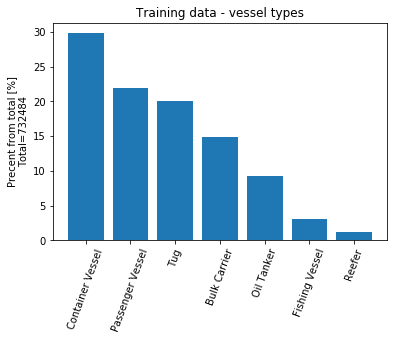

,Count,%
0,665037.0,90.8
1,67447.0,9.2
Total,732484.0,100.0


In [13]:
print_count_col(train_data_labeled, 'type', plot=True,title='Training data - vessel types')
print_count_col(train_data_labeled, 'label', show_table=False, title='Training data - labels')

### Inspect visit duration for oil-tanker and other

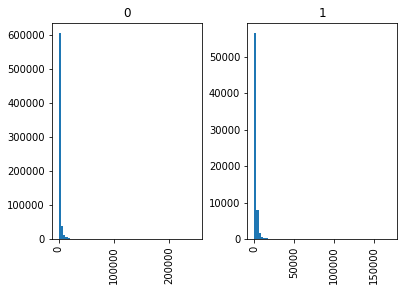

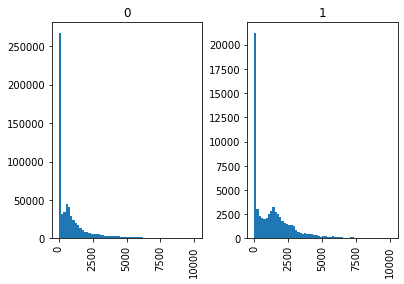

In [14]:
minute_to_day = 60*24
oil_tankers_visit_duration_hist = train_data_labeled.hist(column='duration_min', by=train_data_labeled['label'],
                                                         bins=60)

num_days_to_inspect = 7 #1 #18/24 #1/24 #1/(24*10)
oil_tankers_visit_duration_hist = train_data_labeled.hist(column='duration_min', by=train_data_labeled['label'], 
                                                          bins=60, range=(0, minute_to_day*num_days_to_inspect))

# Notes:
# 1. A large prortion of ships from both kinds (oil-tankers and other) stay very a minute or less. 
#    Next cell I inspect how many (per label and in total)
# 2. There appear to be peaks in durations, at multiplications of ~15 minutes. Similar in both types
# 3. Peak at around 12 hours for non oil-tankers, and at 24 hours for oil-tankers (smaller peak in non-oil-tankers): 
#    this could be a meaningful feature
# 4. There are a few visits over 7 days. 

,Count,%
>1min,609656.0,83.2
<=1min,122828.0,16.8
Total,732484.0,100.0


,Count,%
>1min,552358.0,83.1
<=1min,112679.0,16.9
Total,665037.0,100.0


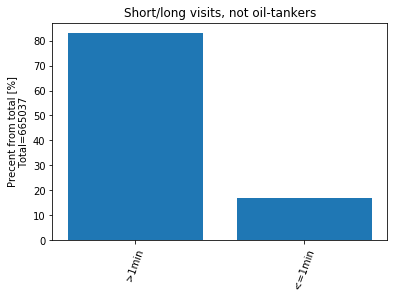

,Count,%
>1min,57298.0,85.0
<=1min,10149.0,15.0
Total,67447.0,100.0


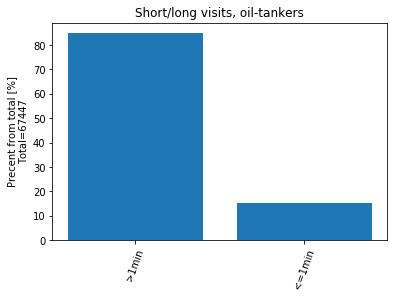

,Count,%
>1min,57298.0,85.0
<=1min,10149.0,15.0
Total,67447.0,100.0


In [15]:
# examine short visits compared to non-short visits, in general, and by label
short_visit_minutes = 1 # chose a very conservative reasonable threshold. todo how to determine more generally?
test_visit_duration = train_data_labeled 
test_visit_duration['short_visit'] = test_visit_duration['duration_min'].apply(lambda x: '<={}min'.format(short_visit_minutes) if x <= short_visit_minutes else '>{}min'.format(short_visit_minutes) )
print_count_col(test_visit_duration, 'short_visit', plot=False, title='Short/long visits')

print_count_col(test_visit_duration[test_visit_duration['label'] == 0], 'short_visit', plot=True, title='Short/long visits, not oil-tankers')

print_count_col(test_visit_duration[test_visit_duration['label'] == 1], 'short_visit', plot=True, title='Short/long visits, oil-tankers')


In [16]:
long_visit = minute_to_day*14
precentile_long_visit = stats.percentileofscore(train_data_labeled['duration_min'], long_visit)
display('{}% visits are shorter than {} days'.format(precentile_long_visit, long_visit/minute_to_day))

precentile_to_keep = 99
duration_th_minutes = round(np.percentile(train_data_labeled['duration_min'],precentile_to_keep))
display('{}% visits are shorter than {} days'.format(precentile_to_keep, round(duration_th_minutes/minute_to_day,1)))

'99.13704599690915% visits are shorter than 14.0 days'

'99% visits are shorter than 12.8 days'

### Add a feature: local_start_hour 

In [17]:
# create datetimes with the right UTC
utc_zone = tz.gettz('UTC')
train_data_labeled['start_time_dt'] = train_data_labeled['start_time'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S').replace(tzinfo=utc_zone) )


In [18]:
visit_range = [min(train_data_labeled['start_time_dt']), max(train_data_labeled['start_time_dt'])]
display('data holds visits between {}'.format(visit_range))

"data holds visits between [Timestamp('2016-01-01 00:00:19+0000', tz='tzwin('UTC')'), Timestamp('2016-06-30 23:52:00+0000', tz='tzwin('UTC')')]"

In [19]:
# create datetimes with local timezone, which is extracted from the docks longitude and latitude. Intermediate dataset is saved, because this operation takes a few minutes
timezone_finder = TimezoneFinder(in_memory=True)

#%%timeit    
train_data_labeled['start_time_local'] = train_data_labeled.apply(lambda visit: get_local_time(visit, timezone_finder), axis=1) 

train_data_labeled.to_csv(port_visits_train_expanded_fn)
display(train_data_labeled)

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,type,label,short_visit,start_time_dt,start_time_local
0,56db7bf5e4b087b8d90a9d5e,2016-03-10 07:55:05,1641,57ce88b62e4e5fe35e7b3008,Indonesia,1.042,103.325,PT,Tug,0,>1min,2016-03-10 07:55:05+00:00,2016-03-10 14:55:05+07:00
1,56d88f20e4b0e60539c699ca,2016-03-31 07:37:35,730,5358fc78b68ca120a07dbca5,China,34.664,119.519,Lianyungang,Container Vessel,0,>1min,2016-03-31 07:37:35+00:00,2016-03-31 15:37:35+08:00
2,56d96b7be4b0cdbda2acd645,2016-06-16 07:24:58,141,5358fc78b68ca120a07dbb33,Netherlands,51.689,4.590,Moerdijk,Tug,0,>1min,2016-06-16 07:24:58+00:00,2016-06-16 09:24:58+02:00
3,56d88f20e4b0e60539c699ca,2016-03-10 05:28:48,931,53720b4f57b2d3980edf9bfa,China,36.016,120.233,Qingdao,Container Vessel,0,>1min,2016-03-10 05:28:48+00:00,2016-03-10 13:28:48+08:00
4,56d835ace4b09b379252ab21,2016-04-26 18:12:19,1,5358fc77b68ca120a07db099,France,47.276,-1.885,Cordemais,Bulk Carrier,0,<=1min,2016-04-26 18:12:19+00:00,2016-04-26 20:12:19+02:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
732479,56d88f20e4b0e60539c699ca,2016-03-20 23:59:11,10516,53749f7d8925ee691cb9b4ea,China,31.363,121.714,Chanxingdao,Container Vessel,0,>1min,2016-03-20 23:59:11+00:00,2016-03-21 07:59:11+08:00
732480,56d96d97e4b0d1ae1fbebd6b,2016-06-13 06:10:45,1625,562cc82a8c0e57be50751ec1,India,18.958,72.941,Jawaharlal Nehru - Nhava Sheva,Container Vessel,0,>1min,2016-06-13 06:10:45+00:00,2016-06-13 11:40:45+05:30
732481,56d9026ce4b0b5eaae32988f,2016-03-16 08:56:22,0,5358fc78b68ca120a07db709,Denmark,55.944,11.767,Rorvig Havn,Passenger Vessel,0,<=1min,2016-03-16 08:56:22+00:00,2016-03-16 09:56:22+01:00
732482,56d9026ce4b0b5eaae32988f,2016-03-16 09:32:12,29,5358fc77b68ca120a07db26a,Denmark,55.962,11.847,Hundested Havn,Passenger Vessel,0,>1min,2016-03-16 09:32:12+00:00,2016-03-16 10:32:12+01:00


In [20]:
# keep the hour of visit docks
train_data_labeled['start_hour_local'] = train_data_labeled['start_time_local'].apply(lambda dt: dt.hour) 
# todo check what happens with Nat and how it categorizes
display(train_data_labeled.dtypes)

ves_id                                    object
start_time                                object
duration_min                               int64
port_id                                   object
country                                   object
Lat                                      float64
Long                                     float64
port_name                                 object
type                                      object
label                                      int64
short_visit                               object
start_time_dt       datetime64[ns, tzwin('UTC')]
start_time_local                          object
start_hour_local                         float64
dtype: object

### Preprocess duration_min UPDATE FEATURES_VERSION

In [21]:
# ## 1.0
# training_preprocessed = train_data_labeled
# features_version = 'feat1.0'
# features_version_description = 'all durations, local start hour, countary'
# display('{}: {}'.format(features_version, features_version_description))

# ## 1.1
# training_preprocessed = train_data_labeled[train_data_labeled['duration_min'] > short_visit_minutes]
# features_version = 'feat1.11'
# features_version_description = 'durations above {}, local start hour, countary'.format(short_visit_minutes)
# display('{}: {}'.format(features_version, features_version_description))

## 1.2
training_preprocessed = train_data_labeled[(train_data_labeled['duration_min'] > short_visit_minutes) &
                                          (train_data_labeled['duration_min'] <= duration_th_minutes)]
features_version = 'feat1.2'
features_version_description = 'durations above {} and below {}, local start hour, countary'.format(short_visit_minutes, duration_th_minutes)
display('{}: {}'.format(features_version, features_version_description))

'feat1.2: durations above 1 and below 18471.0, local start hour, countary'

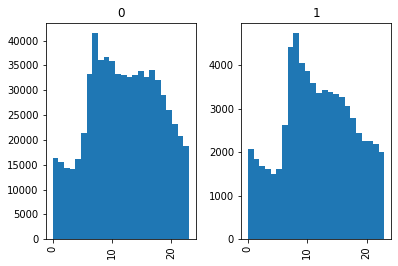

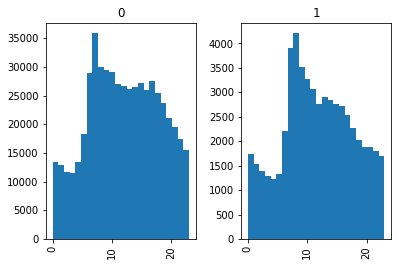

In [22]:
# inspect start_hours before and after preprocessing
# Notes: I don't detect anything insightful 
oil_tankers_start_hour_hist = train_data_labeled.hist(column='start_hour_local', by=train_data_labeled['label'], bins=24)
oil_tankers_start_hour_hist = training_preprocessed.hist(column='start_hour_local', by=train_data_labeled['label'], bins=24)


### Inspect durations at locations, for oil-tankers and others

C:\Users\97254\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


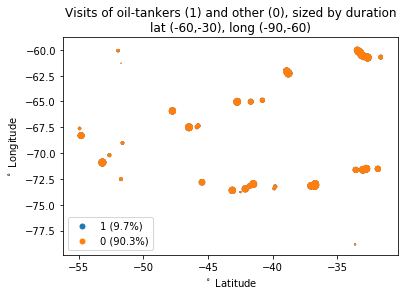

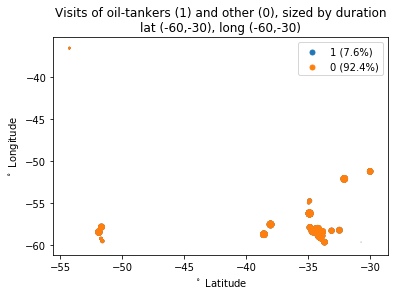

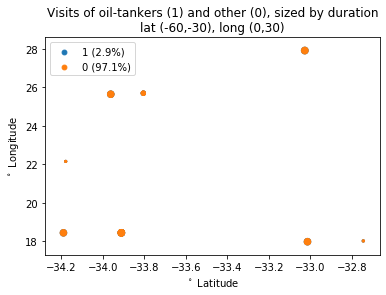

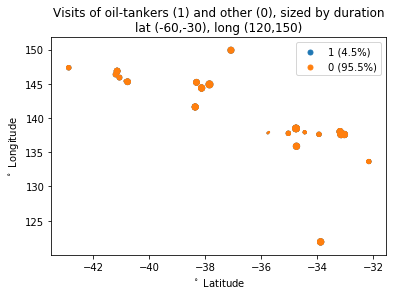

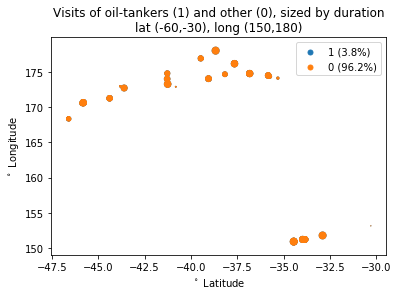

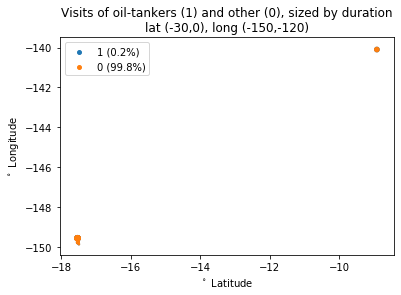

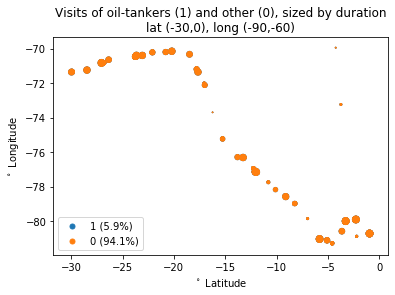

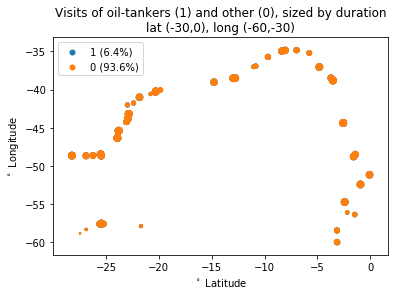

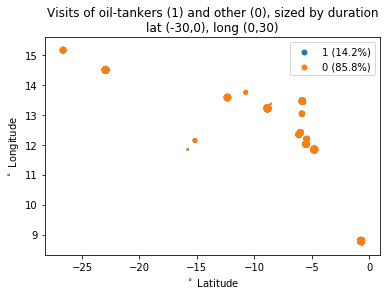

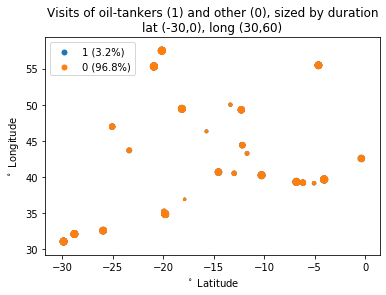

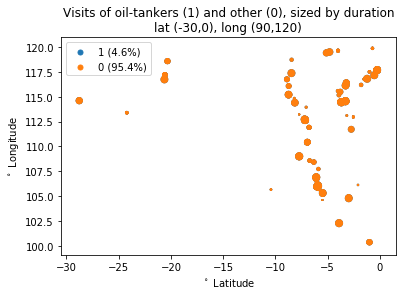

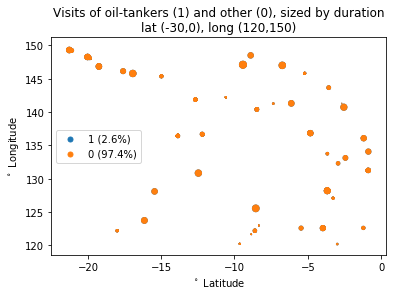

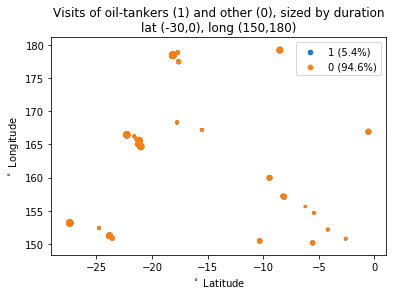

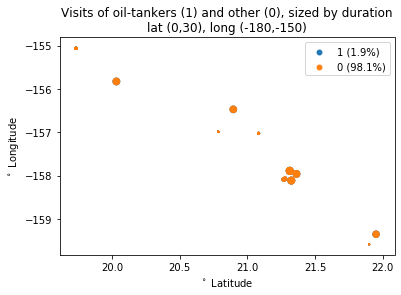

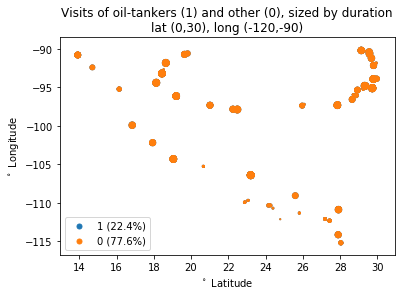

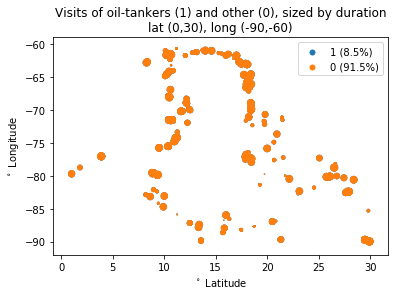

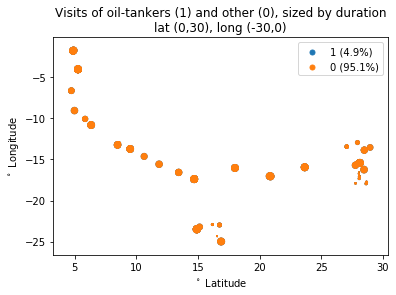

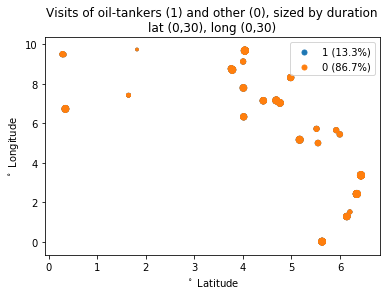

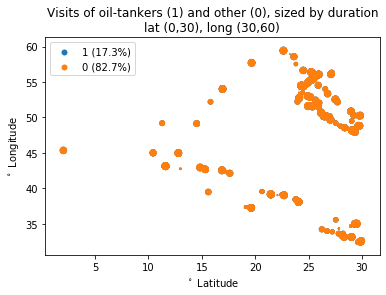

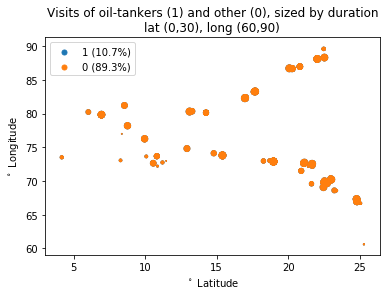

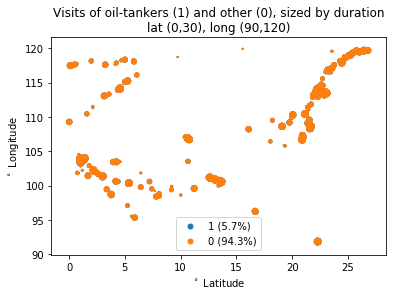

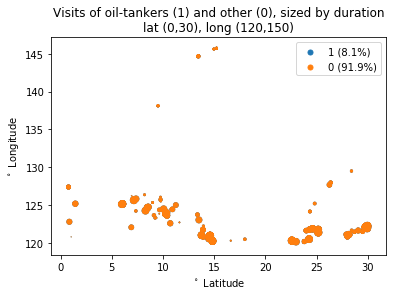

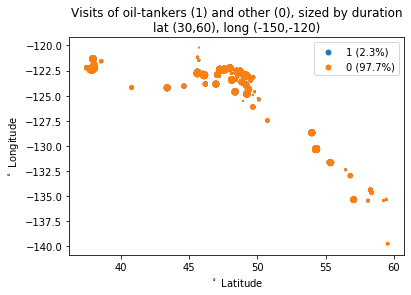

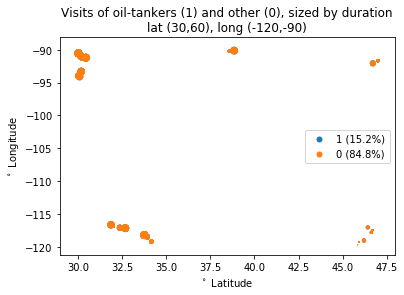

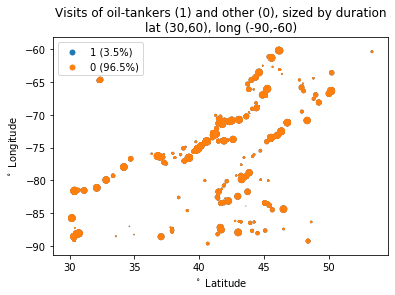

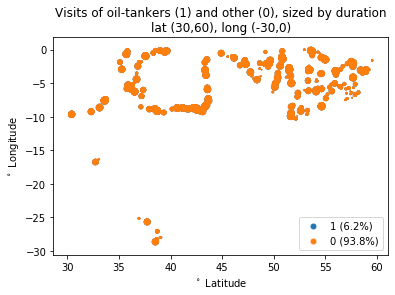

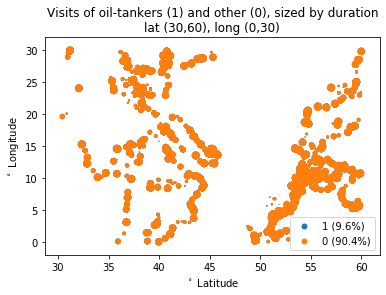

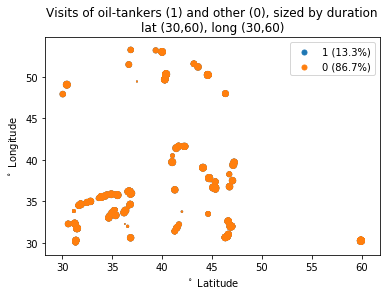

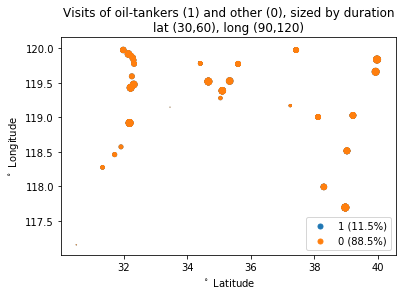

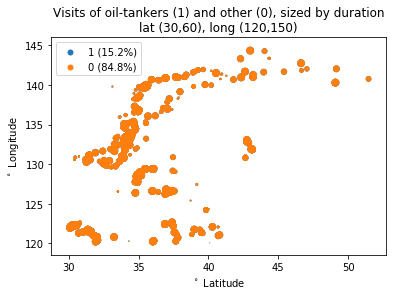

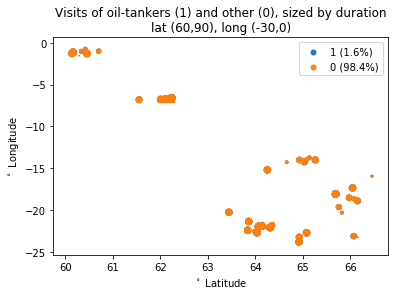

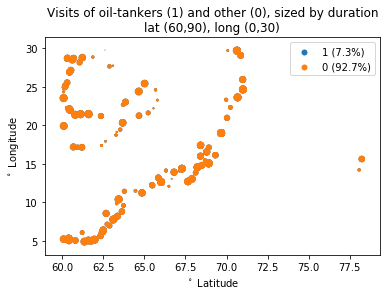

In [23]:
# scatter visits by location, colored by label and sized by duration
# todo: plot in subplots
degree_range = [-180,180]
frame_size = 30
xys = np.mgrid[degree_range[0]:degree_range[1]:frame_size, degree_range[0]:degree_range[1]:frame_size].reshape(2,-1).T
min_visits_4display = 1000
max_point_size = 50

max_duration = max(training_preprocessed['duration_min']) #max(train_data_labeled['duration_min'])

for xy in xys:
    [lat_start,long_start] = xy

    training_frame = training_preprocessed[(train_data_labeled['Lat'] > lat_start) &
                                           (train_data_labeled['Lat'] <= lat_start+frame_size) &
                                           (train_data_labeled['Long'] > long_start) &
                                           (train_data_labeled['Long'] <= long_start+frame_size)]
    
    if training_frame.shape[0] < min_visits_4display:
        #display('Less than {} visits. Skipping display'.format(min_visits_4display))
        continue

    label_count = print_count_col(training_frame, 'label', show_table=False, title='Training data in frame - labels')

    oil_tanker_groups = training_frame.groupby(training_frame['label'])

    for name, group in reversed(tuple(oil_tanker_groups)): # iterating in reverse order so that non-oil-tankers will be plotted on top of oil-tankers
        plt.scatter(training_frame['Lat'], training_frame['Long'], 
                   training_frame['duration_min']/max_duration*max_point_size, # size correlated with duration of visit
             #       training_frame['duration_min']/60, # size correlated with duration of visit
                    label='{} ({}%)'.format(name, label_count.at[name, '%'])) 
    plt.xlabel('$^\circ$ Latitude')
    plt.ylabel('$^\circ$ Longitude')    
    plt.legend()
    plt.title('Visits of oil-tankers (1) and other (0), sized by duration\nlat ({},{}), long ({},{})'.format(lat_start, lat_start+frame_size, long_start, long_start+frame_size))             
    plt.show()

# Here I was worried that becuase I scatter non-oil-tankers first, I don't see them behind the oil-tankers, giving the wrong impression that oil-tankers stay longer. So I also created the same plots in revers order of plotting (  #      training_frame['positive_log_duration'] = training_frame['duration_min'].apply(lambda x: max(1,np.log(x)))


# Modeling

In [24]:
# algorithms 
clf_dict = {"Logistic Regression":LogisticRegression(penalty='l2', C=1, class_weight='balanced', solver='lbfgs'), # 
            "Random Forest": RandomForestClassifier(n_estimators=55, random_state=6),
            "XGBoost": xgb.XGBClassifier()#(objective='multi:softmax')#, num_class=num_class
           }



In [25]:
# evaluation metrics
scoring={'precision':'precision', 
         'recall':'recall', 
         'tnr': make_scorer(tnr_score), 
         'f1':'f1', 
         'roc_auc':'roc_auc',  
         'accuracy':'accuracy' }


In [26]:
# metrics will be kept in a dataframe along with run identifiers: versions, counts, etc.
results_columns = ['features_v', 'features_v_description',
                   'model_v', 'model_name',
                   'num_visits_train', 'oil_tankers_ratio',
#                    'num_cv',
#                    'cv_eval_precision_0.5', 'cv_eval_recall_0.5', 'cv_eval_tnr_0.5', 'cv_eval_f1_0.5', 'cv_eval_acc_0.5', 'cv_eval_roc_auc',
                   'eval_precision_0.5', 'eval_recall_0.5', 'eval_tnr_0.5', 'eval_f1_0.5', 'eval_accuracy_0.5', 
#                    'eval_opt_th', 
#                    'eval _precision_opt', 'eval _recall_opt', 'eval _tnr_opt', 'eval _f1_opt', 'eval _acc_opt'
                   ]
                        

In [27]:
oil_tankers_ratio = round(len(training_preprocessed[training_preprocessed['label']==1])/training_preprocessed.shape[0],2)
display('ratio of oil_tankers in preprocessed data {}'.format(oil_tankers_ratio))

'ratio of oil_tankers in preprocessed data 0.09'

### Define and create categorical features

In [28]:
cat_columns = {'start_hour_local':'hour', 'country':'country'} #, 'port_id':'port'}

features_columns = ['duration_min'] + list(cat_columns.keys())

X_train_full = training_preprocessed[features_columns]
X_train_full = pd.get_dummies(X_train_full, columns=list(cat_columns.keys()), prefix=list(cat_columns.values()))
feature_names = X_train_full.columns
X_train_full.dtypes

duration_min         int64
hour_0.0             uint8
hour_1.0             uint8
hour_2.0             uint8
hour_3.0             uint8
                     ...  
country_Uruguay      uint8
country_Vanuatu      uint8
country_Venezuela    uint8
country_Vietnam      uint8
country_Yemen        uint8
Length: 185, dtype: object

'oil_tanker_results_feat1.2_1.1.csv'

'**************************************************'

'Logistic Regression'

C:\Users\97254\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


'precision for th=0.5 is 0.14808234019501626'

'recall for th=0.5 is 0.6029645314981472'

'tnr for th=0.5 is 0.6397423327499473'

'f1 for th=0.5 is 0.2377705100549718'

'roc_auc for th=0.5 is 0.6213534321240474'

'accuracy for th=0.5 is 0.6362821353565706'

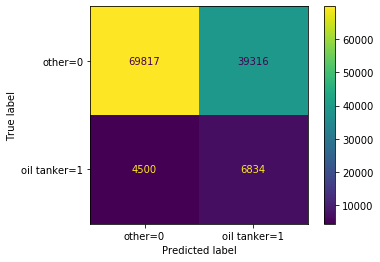

Best Threshold=0.497666


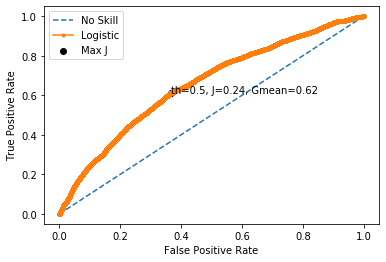

,features_v,features_v_description,model_v,model_name,num_visits_train,oil_tankers_ratio,eval_precision_0.5,eval_recall_0.5,eval_tnr_0.5,eval_f1_0.5,eval_accuracy_0.5,eval_roc_auc_0.5
0,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,Logistic Regression,602331,0.09,0.15,0.6,0.64,0.24,0.64,0.62


'**************************************************'

'Random Forest'

'precision for th=0.5 is 0.24165915238954014'

'recall for th=0.5 is 0.189165343215105'

'tnr for th=0.5 is 0.9383504531168391'

'f1 for th=0.5 is 0.21221419380382064'

'roc_auc for th=0.5 is 0.563757898165972'

'accuracy for th=0.5 is 0.867864228377896'

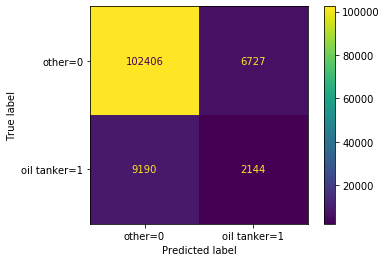

Best Threshold=0.036212


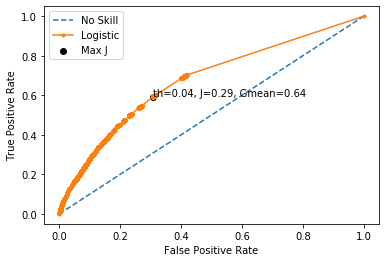

,features_v,features_v_description,model_v,model_name,num_visits_train,oil_tankers_ratio,eval_precision_0.5,eval_recall_0.5,eval_tnr_0.5,eval_f1_0.5,eval_accuracy_0.5,eval_roc_auc_0.5
0,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,Random Forest,602331,0.09,0.24,0.19,0.94,0.21,0.87,0.56


'**************************************************'

'XGBoost'

'precision for th=0.5 is 0.538878842676311'

'recall for th=0.5 is 0.02629257102523381'

'tnr for th=0.5 is 0.9976634015375734'

'f1 for th=0.5 is 0.05013880710019348'

'roc_auc for th=0.5 is 0.5119779862814036'

'accuracy for th=0.5 is 0.9062730872355085'

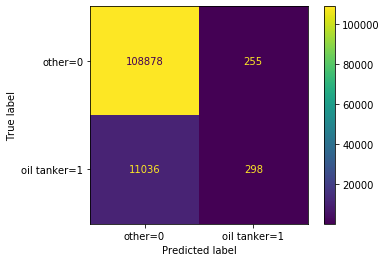

Best Threshold=0.085443


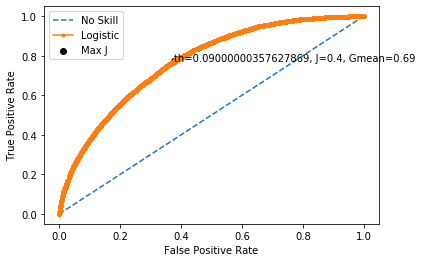

,features_v,features_v_description,model_v,model_name,num_visits_train,oil_tankers_ratio,eval_precision_0.5,eval_recall_0.5,eval_tnr_0.5,eval_f1_0.5,eval_accuracy_0.5,eval_roc_auc_0.5
0,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,XGBoost,602331,0.09,0.54,0.03,1.0,0.05,0.91,0.51


,features_v,features_v_description,model_v,model_name,num_visits_train,oil_tankers_ratio,eval_precision_0.5,eval_recall_0.5,eval_tnr_0.5,eval_f1_0.5,eval_accuracy_0.5,eval_roc_auc_0.5
0,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,Logistic Regression,602331,0.09,0.15,0.60,0.64,0.24,0.64,0.62
1,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,Random Forest,602331,0.09,0.24,0.19,0.94,0.21,0.87,0.56
2,feat1.2,"durations above 1 and below 18471.0, local sta...",1.1,XGBoost,602331,0.09,0.54,0.03,1.00,0.05,0.91,0.51


In [29]:
models_version = 1.1 # without cross validation
version_str = '{features_v}_{models_v}'.format(features_v=features_version, models_v=models_version)
results_fn = 'oil_tanker_results_{version_str}.csv'.format(version_str=version_str)
display(results_fn)

results = pd.DataFrame(columns = results_columns)

num_cv=1

y_train_full = training_preprocessed['label']
labels=np.unique(y_train_full).tolist()

X_train, X_eval, y_train, y_eval = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

for c_name,clf in clf_dict.items():
    display('*'*50)
    display(c_name)
        
    res = pd.DataFrame(columns = results_columns)
    res['features_v'] = [features_version]
    res['features_v_description'] = [features_version_description]
    res['model_v'] = [models_version]
    res['model_name'] = [c_name]
    res['num_visits_train'] = [len(y_train_full)]
    res['oil_tankers_ratio'] = [oil_tankers_ratio]
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_eval)
    y_proba = clf.predict_proba(X_eval)[:, 1]
    
    default_th = 0.5
    for s in scoring:
        res['eval_{}_0.5'.format(s)] = [round(metric_at_th(s, y_eval, y_proba, default_th),2)]

#    plotting the confusion matrix
    p = plot_confusion_matrix(clf, X_eval, y_eval, display_labels=['other=0', 'oil tanker=1'],values_format='.0f')
    plt.show()
    
    # get the best threshold
    fpr, tpr, thresholds = roc_curve(y_eval, y_proba)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    fig, ax = plt.subplots(1,1)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Max J')
    max_G_mean = np.sqrt(tpr[ix] * (1-fpr[ix]))
    plt.text(fpr[ix], tpr[ix], 'th={}, J={}, Gmean={}'.format(round(best_thresh,2), round(J[ix],2), round(max_G_mean,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
#     # cross validating to get scores: took too long, and not really needed for randomForest and xgBoost
#     res['num_cv'] = [num_cv]
#     cross_val_res = cross_validate(clf, X_train, y_train, cv=num_cv, scoring=scoring)#, return_train_score=True)
#     for s in scoring:
#         test_scores = cross_val_res['test_' + s]
#         #display('eval {} : {}+-{}%'.format(s, round(test_scores.mean()*100,1), round(test_scores.std()*100,1) ))
#         res['cv_eval_{}_0.5'.format(s)] = [round(test_scores.mean(),2)]
                        
# #         train_scores = cross_val_res['train_' + s]
# #         #display('training {} : {}+/-{}%'.format(s, round(train_scores.mean()*100,1), round(train_scores.std()*100,1) ))
# #         res['train_{}_0.5'.format(s)] = [round(train_scores.mean(),2)]
        
#     # finding the best th and getting scores for that th
#     best_th = get_optimal_f1_th(y_eval, y_proba)
#         res['eval_opt_th'] = [best_th]
#     for s in scoring if s!='roc_auc':
#       display(round(metric_at_th(s, y_eval, y_proba, best_th),2))
#       res['eval_{}_opt'.format(s)] = [round(metric_at_th(s, y_eval, y_proba, best_th),2)]
    
    display(res)    
    results = results.append(res,sort=False,ignore_index=True)
    results[results_columns].to_csv(results_fn) # saving after every model is tested
    
    # save the model
    model_name_forsave = ''.join([word[0] for word in c_name.split()])
    model_filename = 'oiltanker_{model_name}_{version_str}.bin'.format(model_name=model_name_forsave, version_str=version_str)
    dump(clf, model_filename)

display(results)

 

## Predict on test data

In [49]:
## load test data
port_visits_test_fn = 'port_visits_test.csv'
port_visits_test = pd.read_csv(port_visits_test_fn)
display(port_visits_test.head(5))


,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name
0,56d83493e4b0eadad23479b4,2016-02-10 22:15:15,195,5358fc78b68ca120a07dbbc9,Japan,34.559,135.417,Sakai
1,56dd13bee4b031148077db47,2016-02-26 12:50:31,0,5358fc78b68ca120a07dbcc0,Greece,37.951,23.604,Piraeus
2,56dd13bee4b031148077db47,2016-03-01 10:42:45,1207,5358fc78b68ca120a07db851,Greece,37.435,24.942,Siros Ermoupoli
3,56d84de7e4b099a29d07395d,2016-03-19 03:08:13,50,5358fc78b68ca120a07dbcac,UnitedStates,30.711,-88.049,Mobile
4,56d84de7e4b099a29d07395d,2016-04-02 03:39:51,1692,5358fc78b68ca120a07dbcac,UnitedStates,30.711,-88.049,Mobile


In [50]:
# create features on test data
# create datetimes with the right UTC
utc_zone = tz.gettz('UTC')
port_visits_test['start_time_dt'] = port_visits_test['start_time'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S').replace(tzinfo=utc_zone) )

visit_range = [min(port_visits_test['start_time_dt']), max(port_visits_test['start_time_dt'])]
display('data holds visits between {}'.format(visit_range)) # test and train hold same range of dates

# create datetimes with local timezone, which is extracted from the docks longitude and latitude. Intermediate dataset is saved, because this operation takes a few minutes
timezone_finder = TimezoneFinder(in_memory=True) 
port_visits_test['start_time_local'] = port_visits_test.apply(lambda visit: get_local_time(visit, timezone_finder), axis=1) 

# keep the hour of visit docks
port_visits_test['start_hour_local'] = port_visits_test['start_time_local'].apply(lambda dt: dt.hour)
display(port_visits_test.dtypes)
display(port_visits_test.head(5))

"data holds visits between [Timestamp('2016-01-01 00:02:40+0000', tz='tzwin('UTC')'), Timestamp('2016-06-30 23:59:07+0000', tz='tzwin('UTC')')]"

ves_id                                    object
start_time                                object
duration_min                               int64
port_id                                   object
country                                   object
Lat                                      float64
Long                                     float64
port_name                                 object
start_time_dt       datetime64[ns, tzwin('UTC')]
start_time_local                          object
start_hour_local                         float64
dtype: object

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,start_time_dt,start_time_local,start_hour_local
0,56d83493e4b0eadad23479b4,2016-02-10 22:15:15,195,5358fc78b68ca120a07dbbc9,Japan,34.559,135.417,Sakai,2016-02-10 22:15:15+00:00,2016-02-11 07:15:15+09:00,7.0
1,56dd13bee4b031148077db47,2016-02-26 12:50:31,0,5358fc78b68ca120a07dbcc0,Greece,37.951,23.604,Piraeus,2016-02-26 12:50:31+00:00,2016-02-26 14:50:31+02:00,14.0
2,56dd13bee4b031148077db47,2016-03-01 10:42:45,1207,5358fc78b68ca120a07db851,Greece,37.435,24.942,Siros Ermoupoli,2016-03-01 10:42:45+00:00,2016-03-01 12:42:45+02:00,12.0
3,56d84de7e4b099a29d07395d,2016-03-19 03:08:13,50,5358fc78b68ca120a07dbcac,UnitedStates,30.711,-88.049,Mobile,2016-03-19 03:08:13+00:00,2016-03-18 22:08:13-05:00,22.0
4,56d84de7e4b099a29d07395d,2016-04-02 03:39:51,1692,5358fc78b68ca120a07dbcac,UnitedStates,30.711,-88.049,Mobile,2016-04-02 03:39:51+00:00,2016-04-01 22:39:51-05:00,22.0


In [51]:
# create categorical features
X_test = port_visits_test[features_columns]
X_test = pd.get_dummies(X_test, columns=list(cat_columns.keys()), prefix=list(cat_columns.values()))
test_feature_names = X_test.columns
display(X_test.shape)

(192708, 180)

In [52]:
# match test data features to training-data features
mutual_features = list(set(feature_names) & set(test_feature_names))
display('there are {} mutual_features'.format(len(mutual_features)))

# keep features that are mutual
X_test = X_test[mutual_features]
display(X_test.shape)

# add missing features with value 0
features_only_in_train = list(set(feature_names) - set(mutual_features))
display(features_only_in_train)
for feat in features_only_in_train:
    X_test[feat] = 0
display('# training features {}, # test features {}'.format(len(feature_names), len(X_test.columns)))

'there are 180 mutual_features'

(192708, 180)

['country_North Korea',
 'country_Antarctica',
 'country_Nauru',
 'country_Belize',
 'country_Papua New Guinea']

'# training features 185, # test features 185'

In [53]:
# load the chosen model
# I chose RandomForest because it had the best f1, which I chose as the lead metric (I'll be happy to explain why)
model_name = 'RF' # RandomForest
version_str = version_str
model_filename = 'oiltanker_{model_name}_{version_str}.bin'.format(model_name=model_name, version_str=version_str)
clf = load(model_filename)
display(clf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [54]:
# predict
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

In [55]:
# attach predictions to test visits
test_data_predicted = port_visits_test
test_data_predicted['y_pred'] = y_test_pred
test_data_predicted['y_proba'] = y_test_proba
display(test_data_predicted.head(2))

def pred_mode(x): return x.value_counts().index[0]
# group by vessel id
vessels_predictions = test_data_predicted.groupby(['ves_id'], as_index=False).agg({'y_proba': ['count', 'mean'], 
                                                                                   'y_pred': pred_mode})

vessels_predictions.columns = [' '.join(col).strip() for col in vessels_predictions.columns.values] # flattening for convinience
display(vessels_predictions)

,ves_id,start_time,duration_min,port_id,country,Lat,Long,port_name,start_time_dt,start_time_local,start_hour_local,y_pred,y_proba
0,56d83493e4b0eadad23479b4,2016-02-10 22:15:15,195,5358fc78b68ca120a07dbbc9,Japan,34.559,135.417,Sakai,2016-02-10 22:15:15+00:00,2016-02-11 07:15:15+09:00,7.0,0,0.039394
1,56dd13bee4b031148077db47,2016-02-26 12:50:31,0,5358fc78b68ca120a07dbcc0,Greece,37.951,23.604,Piraeus,2016-02-26 12:50:31+00:00,2016-02-26 14:50:31+02:00,14.0,0,0.000000


,ves_id,y_proba count,y_proba mean,y_pred pred_mode
0,56d83489e4b01c7098934f4b,16,0.193818,0
1,56d83489e4b02c65b7730d6e,42,0.080567,0
2,56d83489e4b0ad1bfa26097c,25,0.061475,0
3,56d83489e4b0ad1bfa26097f,15,0.106537,0
4,56d83489e4b0c8d95c300903,65,0.826611,1
...,...,...,...,...
5280,576e9d69b62df54e5326a49a,2,0.181737,0
5281,577002f170ffb24ccc3d5ba9,1,0.293939,0
5282,5771bb9021a04d3daacfc7b4,2,0.140203,0
5283,57722a957da91d36e7e426b2,1,0.076831,0


In [63]:
# load vessels to label and attach predictions to vessels
vessels_to_label_fn = 'vessels_to_label.csv'
vessels_to_label = pd.read_csv(vessels_to_label_fn, header=None, names = ['ves_id'])
display(vessels_to_label.head(2))


precited_vessels = pd.merge(vessels_to_label, vessels_predictions, 
                            how='left', indicator=True) # choosing mode because natural for random-forest

display(precited_vessels.head(3))

num_missing_labels = precited_vessels[precited_vessels['_merge'] != 'both'].shape[0]
display('Could not predict {} (={}%) vessels for which there is no data. Assigning majority (not oil-tanker)'.format(num_missing_labels, 
                                                                                            round(num_missing_labels/vessels_to_label.shape[0]*100,1))) #I'm assuming that training data is usually not available during predictions
# assign not-oil-tanker to vessels with no data
precited_vessels.loc[precited_vessels['_merge'] != 'both','y_pred pred_mode'] = 0 # todo: get the majority value from the data, instead of hard-coded

precited_vessels = precited_vessels[['ves_id', 'y_pred pred_mode']]
precited_vessels.columns = ['vesselid', 'label']

display(precited_vessels)


,ves_id
0,56d96b7be4b0f124c80a36de
1,56d8a83ce4b04fc05eea8f1a


,ves_id,y_proba count,y_proba mean,y_pred pred_mode,_merge
0,56d96b7be4b0f124c80a36de,7.0,0.169622,0.0,both
1,56d8a83ce4b04fc05eea8f1a,85.0,0.067193,0.0,both
2,56d85613e4b0586d5d8bd194,29.0,0.072509,0.0,both


'Could not predict 125 (=2.3%) vessels for which there is no data. Assigning majority (not oil-tanker)'

,vesselid,label
0,56d96b7be4b0f124c80a36de,0.0
1,56d8a83ce4b04fc05eea8f1a,0.0
2,56d85613e4b0586d5d8bd194,0.0
3,56d83890e4b04eb0dbddad00,0.0
4,56d85370e4b06d6d2299ede7,0.0
...,...,...
5405,56dc3564e4b009004fbdfcf4,0.0
5406,56d8348ce4b0c8d95c300982,0.0
5407,56d835afe4b07096ffb1f2f2,0.0
5408,56dac8cee4b0244e87e6e549,0.0


In [67]:
# save predictions

test_predictions_fn = 'test_predictions_{}.csv'.format(model_filename)
precited_vessels.to_csv(test_predictions_fn, index=False)
display('saved predictions: {}'.format(test_predictions_fn))

'saved predictions: test_predictions_oiltanker_RF_feat1.2_1.1.bin.csv'

## Todo

### First, I would learn about the domain!

### Features
1. Better cleaning of durations: choose better thresholds for short/long; instead of deleting assign median duration
2. Bin durations (?)
3. Add port as a categorical feature (not sure... too many!)
4. Inspect days of week distribution? (after consulting with a domain-expert if that's reasonable at all)
5. Inspect distribution of visits to ports. Perhaps there are some ports which are visited mostly by oil-tankers. If so, create    a list of ports that were visited by oil-tankers, and add a feature: "port was/was not visited by oil-tankers" (or something)

### Modeling
1. Inspect features importance!!! 
2. Play with algorithms parameters. Especially xgboost
3. Extract optimal threshold and run with that

### Assignment
1. Convert to a few notebooks (data_inspection, create_training_dataset, model, predict)


In [ ]:
test